In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
#### salimt

import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-08-07 07:35:20--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.02s   

2020-08-07 07:35:20 (2.92 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



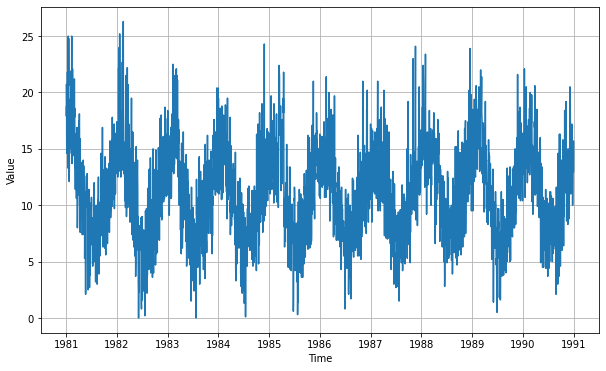

In [15]:
import csv
from datetime import datetime
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(datetime.strptime(row[0], '%Y-%m-%d').date())

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [16]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [17]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [18]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [19]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 10
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 1s 52ms/step - loss: 31.1571 - mae: 31.6550
Epoch 2/100
10/10 [==============================] - 1s 55ms/step - loss: 30.5778 - mae: 31.0756
Epoch 3/100
10/10 [==============================] - 1s 53ms/step - loss: 29.6825 - mae: 30.1801
Epoch 4/100
10/10 [==============================] - 1s 54ms/step - loss: 28.5613 - mae: 29.0586
Epoch 5/100
10/10 [==============================] - 1s 56ms/step - loss: 27.1974 - mae: 27.6945
Epoch 6/100
10/10 [==============================] - 1s 55ms/step - loss: 25.5017 - mae: 25.9986
Epoch 7/100
10/10 [==============================] - 1s 57ms/step - loss: 23.3464 - mae: 23.8429
Epoch 8/100
10/10 [==============================] - 1s 61ms/step - loss: 20.6148 - mae: 21.1108
Epoch 9/100
10/10 [==============================] - 1s 56ms/step - loss: 17.3142 - mae: 17.8091
Epoch 10/100
10/10 [=====

(1e-08, 0.0001, 0.0, 60.0)

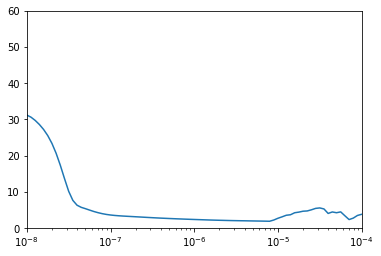

In [20]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [70]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=64, batch_size=128, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=128, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/500
20/20 [==============================] - 1s 34ms/step - loss: 2.4279 - mae: 2.8881
Epoch 2/500
20/20 [==============================] - 1s 39ms/step - loss: 1.8693 - mae: 2.3215
Epoch 3/500
20/20 [==============================] - 1s 40ms/step - loss: 1.7751 - mae: 2.2255
Epoch 4/500
20/20 [==============================] - 1s 41ms/step - loss: 1.6915 - mae: 2.1393
Epoch 5/500
20/20 [==============================] - 1s 41ms/step - loss: 1.6571 - mae: 2.1039
Epoch 6/500
20/20 [==============================] - 1s 41ms/step - loss: 1.6416 - mae: 2.0876
Epoch 7/500
20/20 [==============================] - 1s 39ms/step - loss: 1.6143 - mae: 2.0590
Epoch 8/500
20/20 [==============================] - 1s 41ms/step - loss: 1.6417 - mae: 2.0880
Epoch 9/500
20/20 [==============================] - 1s 41ms/step - loss: 1.6253 - mae: 2.0710
Epoch 10/500
20/20 [==============================] - 1s 44ms/step - loss: 1.5615 - mae: 2.0041
Epoch 11/500
20/20 [=============================

In [71]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

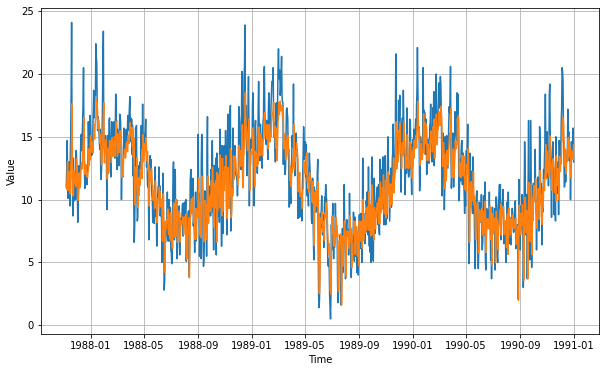

In [72]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [73]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.80795

In [74]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.215938 10.823495 12.160742 ... 13.233356 13.18739  14.375239]
